<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow P. 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to ours.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a gpu?
!nvidia-smi

Thu Jul  7 17:11:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and become one with the data



In [ ]:
# Get data (10% of food classes from Food101)
import zipfile

# download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref =zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2022-07-07 17:11:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  46.1MB/s    in 3.5s    

2022-07-07 17:11:42 (46.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak

## Creating data loaders (preparing the data)

We'll use `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMG_SHAPE,
                                                        batch_size=BATCH_SIZE)

Training Images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (functions to run while our mode trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

In [ ]:
# Create TensorBoard callback (Functionized because we need to create a new one for each model)
import datetime


def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hubs

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:

# Let's compare the following two models:

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  # Download pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE +(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating ResNet TensorFlow Hub feature extraction model

In [ ]:
# Create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Train model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=10,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_steps=len(test_data),
                 validation_data=test_data,
                 callbacks=[create_tensorboard_callback("tf_hub", "resnet50V2")])

Saving TensorBoard log files to: tf_hub/resnet50V2/20220707-171159
Epoch 1/10
24/24 [==============================] - 32s 734ms/step - loss: 1.9994 - accuracy: 0.3293 - val_loss: 1.2501 - val_accuracy: 0.5856
Epoch 2/10
24/24 [==============================] - 15s 664ms/step - loss: 0.9353 - accuracy: 0.7307 - val_loss: 0.8758 - val_accuracy: 0.7184
Epoch 3/10
24/24 [==============================] - 16s 675ms/step - loss: 0.6359 - accuracy: 0.8307 - val_loss: 0.7707 - val_accuracy: 0.7456
Epoch 4/10
24/24 [==============================] - 15s 660ms/step - loss: 0.4831 - accuracy: 0.8653 - val_loss: 0.7143 - val_accuracy: 0.7612
Epoch 5/10
24/24 [==============================] - 15s 658ms/step - loss: 0.3888 - accuracy: 0.9107 - val_loss: 0.6773 - val_accuracy: 0.7736
Epoch 6/10
24/24 [==============================] - 15s 656ms/step - loss: 0.3118 - accuracy: 0.9453 - val_loss: 0.6736 - val_accuracy: 0.7736
Epoch 7/10
24/24 [==============================] - 20s 861ms/step - loss: 

Wow!

That. Is. incredible. Our transfer learning feature extractor model outperformed ALL of the previous models we built by hand... (substantially), in a quicker training time, AND with only 10% of the training examples.

In [ ]:
# Let's create our function  to plot our loss curves

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history ('keras.callbacks.History'): Tensorflow history object

  Returns:
    Plots of training/validation loss and accuracy metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label="training_loss");
  plt.plot(epochs, val_loss, label="val_loss");
  plt.title("Loss");
  plt.xlabel("Epochs");
  plt.legend();

  # Plot accuracy
  plt.figure();
  plt.plot(epochs, accuracy, label="training_accuracy");
  plt.plot(epochs, val_accuracy, label="val_accuracy");
  plt.title("Accuracy");
  plt.legend()

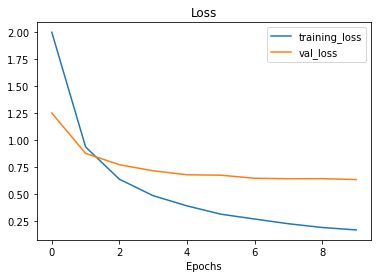

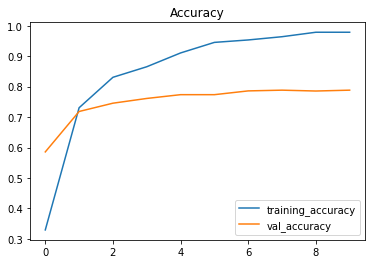

In [ ]:
plot_loss_curves(resnet_history)

### Creating EfficientNetB0 TensorFlow Hub feature extraction model

Info on Efficient net B0: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html


In [ ]:
# Create model
efficientnet_b0 = create_model(efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)

In [ ]:
efficientnet_b0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# How many layers does our efficientnet feature extractor have
len(efficientnet_b0.layers[0].weights)

309

In [ ]:
# Compile model
efficientnet_b0.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [ ]:
efficientnet_history = efficientnet_b0.fit(train_data_10_percent,
                                           epochs=10,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[create_tensorboard_callback("tf_hub","efficient_net_b0")]
                                           )

Saving TensorBoard log files to: tf_hub/efficient_net_b0/20220707-172443
Epoch 1/10
24/24 [==============================] - 25s 703ms/step - loss: 1.8293 - accuracy: 0.4413 - val_loss: 1.2819 - val_accuracy: 0.7460
Epoch 2/10
24/24 [==============================] - 15s 640ms/step - loss: 1.0480 - accuracy: 0.7787 - val_loss: 0.8512 - val_accuracy: 0.8248
Epoch 3/10
24/24 [==============================] - 15s 644ms/step - loss: 0.7444 - accuracy: 0.8387 - val_loss: 0.6842 - val_accuracy: 0.8484
Epoch 4/10
24/24 [==============================] - 15s 655ms/step - loss: 0.5971 - accuracy: 0.8720 - val_loss: 0.6027 - val_accuracy: 0.8580
Epoch 5/10
24/24 [==============================] - 15s 649ms/step - loss: 0.5015 - accuracy: 0.8947 - val_loss: 0.5491 - val_accuracy: 0.8628
Epoch 6/10
24/24 [==============================] - 15s 645ms/step - loss: 0.4352 - accuracy: 0.9093 - val_loss: 0.5130 - val_accuracy: 0.8668
Epoch 7/10
24/24 [==============================] - 15s 643ms/step - 

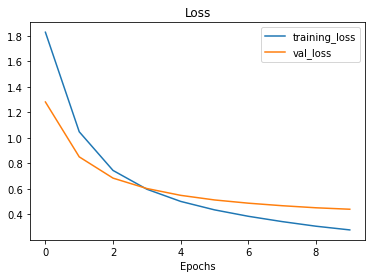

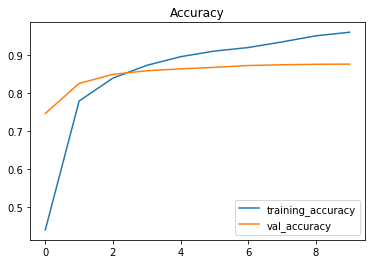

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is" transfer learning -** using an existing model with no changes (e.g. using ImageNet model on 1000 ImageNet classes, none of our own).

* **"Feature extraction" transfer learning -** Use prelearned patterns of an existing model (e.g EfficientNetB0 trained on image net) and adjust the output layer for our own problem (e.g. 1000 classes -> 10 classes of food).

* **"Fine-Tuning" transfer learning -** use prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

---



## Comparing our models results using TensorBoard

>**Note -** When we upload things to TensorBoard.dev, our experiments are public. So if we're running private experiments (whatever we don't want others to see, do not upload them to tensorboard.dev)

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tf_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tf_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=IESBuT49vXX0BZS2X0wHHzAX0nBSVV&prompt=consent&access_type=offline
Ent

Our TensorBoard experiments are uploaded publically here https://tensorboard.dev/experiment/EQqrj890ROyiec11Gyabsg/

If we want to check out which experiments we have on TensorBoard:

In [ ]:
# Check out what TensorBoard experiments we have

!tensorboard dev list

https://tensorboard.dev/experiment/EQqrj890ROyiec11Gyabsg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   EQqrj890ROyiec11Gyabsg
	Created              2022-07-07 18:11:09 (5 minutes ago)
	Updated              2022-07-07 18:11:15 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  5921878
Total: 1 experiment(s)


If we want to delete an experiment:

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id EQqrj890ROyiec11Gyabsg

In [ ]:
# Confirm deletion by re-checking what experients are left
!tensorboard dev list

https://tensorboard.dev/experiment/EQqrj890ROyiec11Gyabsg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   EQqrj890ROyiec11Gyabsg
	Created              2022-07-07 18:11:09 (8 minutes ago)
	Updated              2022-07-07 18:11:15 (8 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  5921878
Total: 1 experiment(s)
